--- Competitive equilibrium simulation (price-taking + tâtonnement) initialized ---
--- Simulation completed ---
Periods: 232
Leading firm: 13 (Share: %99.33)


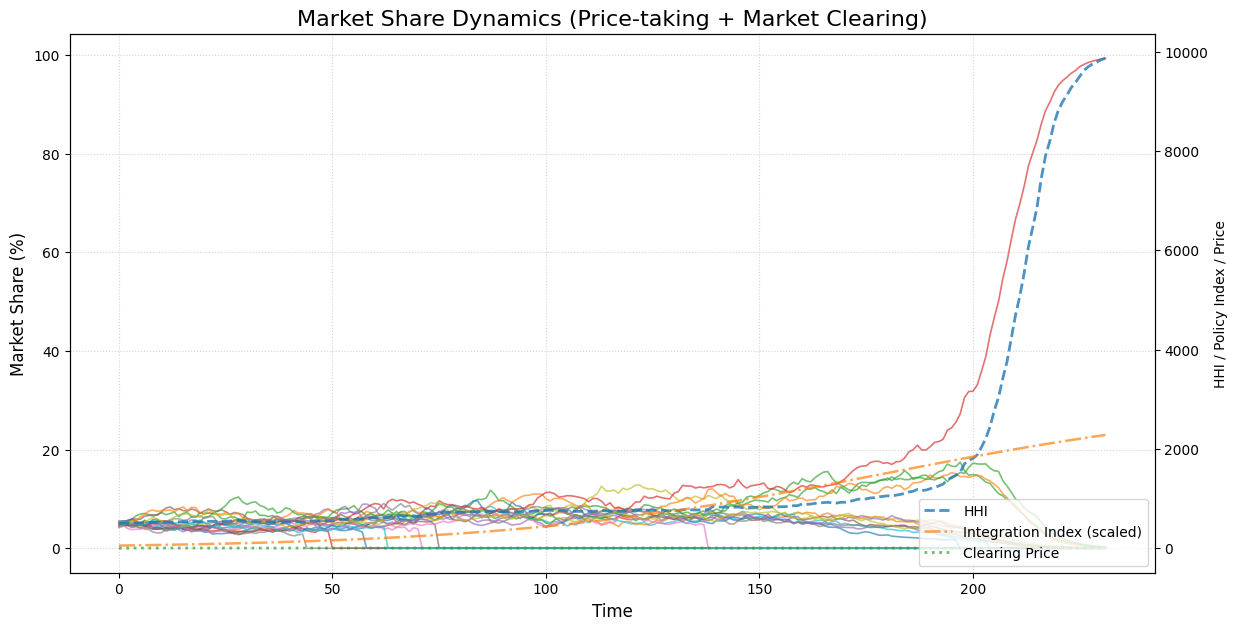

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random


class Firm:
    def __init__(self, firm_id, market_share):
        self.id = firm_id
        self.market_share = market_share
        self.cash = 1000.0
        self.active = True
        self.color = (random.random(), random.random(), random.random())

        # Heterogeneous fundamentals (technology / intangibles / capacity)
        self.productivity = random.uniform(0.85, 1.15)
        self.brand_value = random.uniform(0.85, 1.15)
        self.capital_stock = random.uniform(0.9, 1.1)

        # Balance-sheet friction proxy (looks innocuous)
        self.risk_premium = random.uniform(0.9, 1.1)


def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))


# --- GE-looking blocks (Walrasian price adjustment + market clearing) ---

def aggregate_demand(price, market_size, L, elasticity=1.15, preference_shift=0.12):
    """
    Reduced-form demand: D(p) = A(L) * p^{-epsilon}
    Looks like standard GE demand with a policy/preference shifter A(L).
    """
    A = market_size * (1.0 + preference_shift * L)
    return A * (max(price, 1e-6) ** (-elasticity))


def firm_unit_cost(f: Firm, L, scale):
    """
    Unit cost is 'competitive technology' with capacity and finance frictions.
    Hidden: scale-linked efficiency becomes increasingly relevant with L.
    """
    # "capacity utilization / organization efficiency" (monotone in scale when L rises)
    organization_term = 1.0 - 0.55 * (L ** 1.35) * np.sqrt(max(scale, 0.0))
    organization_term = max(0.55, organization_term)

    # capital deepening reduces costs slightly (standard in macro/GE)
    k_term = 1.0 / max(0.75, np.sqrt(max(f.capital_stock, 1e-6)))

    # finance friction proxy (risk premium)
    finance_term = 1.0 + 0.04 * (L ** 1.1) * f.risk_premium

    base = (0.92 * organization_term) * k_term * finance_term
    tech = 1.0 / max(0.75, f.productivity)
    return base * tech


def aggregate_supply(active_firms, price, L, capacity_scale=1.0):
    """
    Competitive supply: each firm supplies more when p exceeds (unit) cost,
    scaled by capacity. This is just a clean GE-looking closure.
    """
    Q = 0.0
    for f in active_firms:
        scale = f.market_share / 100.0
        uc = firm_unit_cost(f, L, scale)
        margin = (price / max(uc, 1e-6)) - 1.0
        if margin > 0:
            capacity = capacity_scale * (0.75 + 0.6 * np.sqrt(max(f.capital_stock, 1e-6)))
            Q += capacity * margin
    return Q


def tatonnement_price(prev_price, active_firms, market_size, L,
                      elasticity=1.15,
                      tatonnement_steps=18,
                      tatonnement_speed_min=0.04,
                      tatonnement_speed_max=0.22):
    """
    Walrasian tâtonnement: p_{k+1} = p_k * (1 + kappa(L) * excess_demand_ratio)
    Faster adjustment with L -> looks like better-integrated markets.
    """
    p = max(prev_price, 1e-3)
    kappa = tatonnement_speed_min + (tatonnement_speed_max - tatonnement_speed_min) * L

    for _ in range(tatonnement_steps):
        D = aggregate_demand(p, market_size, L, elasticity=elasticity)
        S = aggregate_supply(active_firms, p, L)

        # excess demand ratio (bounded)
        denom = max(1e-6, 0.5 * (D + S))
        x = (D - S) / denom
        x = float(np.clip(x, -0.8, 0.8))

        p = p * (1.0 + kappa * x)
        p = float(np.clip(p, 0.25, 5.0))

    return p


def market_simulation(
    n_firms=20,
    max_periods=1000,
    seed=None,

    # Market scale (GE-style)
    market_size=1200,
    initial_price=1.0,

    # "Liberalization / integration" path
    liberalization_midpoint=180,
    liberalization_steepness=45,

    # Convergence dynamics (shares adjust faster as markets integrate)
    adjustment_min=0.05,
    adjustment_max=0.26,
    noise_min=0.015,
    noise_max=0.075,

    # CES-like demand allocation (quality/availability)
    substitution_strength=1.35,
    information_diffusion_strength=2.15,   # (looks like "information", behaves like network effect)
    diffusion_curvature=1.6,

    # Cost structure (fixed costs rise with "openness"/complexity)
    fixed_cost_level=55,
    fixed_cost_sensitivity=0.85,

    # Balance-sheet / finance channel
    financial_depth_strength=18.0,

    # Reallocation rule (looks like "efficient reallocation"; is convex -> concentration)
    reallocation_convexity=0.95,

    # Optional "coordination standard" episode (looks benign; accelerates lock-in)
    coordination_episode=True,
    coordination_intensity=0.18,
    coordination_bonus=0.20,
    coordination_cost=75.0
):
    random.seed(seed)
    np.random.seed(seed)

    firms = [Firm(i, 100.0 / n_firms) for i in range(n_firms)]

    history = []
    concentration_series = []
    liberalization_series = []
    price_series = []
    active_firms_series = []

    t = 0
    price = float(initial_price)

    print("--- Competitive equilibrium simulation (price-taking + tâtonnement) initialized ---")

    while len([f for f in firms if f.active]) > 1 and t < max_periods:
        t += 1

        # Integration index
        L = logistic((t - liberalization_midpoint) / liberalization_steepness)
        liberalization_series.append(float(L))

        # Adjustment + noise (faster adjustment, lower idiosyncratic noise when integrated)
        adjustment_speed = adjustment_min + (adjustment_max - adjustment_min) * L
        noise_sigma = noise_max - (noise_max - noise_min) * L

        active = [f for f in firms if f.active]
        if not active:
            break

        # --- GE-looking: Market-clearing price (Walrasian tâtonnement) ---
        price = tatonnement_price(
            prev_price=price,
            active_firms=active,
            market_size=market_size,
            L=L,
            elasticity=1.15
        )

        # --- Market share dynamics (CES-like demand allocation) ---
        # Consumers allocate expenditure across varieties by "quality" (brand/productivity/capacity)
        # plus an "information diffusion" term that increases with observed adoption.
        scores = []
        for f in active:
            scale = f.market_share / 100.0

            fundamentals = (
                0.95 * f.productivity
                + 0.90 * f.brand_value
                + 0.35 * np.log(max(f.capital_stock, 1e-6))
            )

            # "information / search / adoption" channel (acts like network effect; ramps up with L)
            diffusion = information_diffusion_strength * (L ** diffusion_curvature) * np.log1p(max(f.market_share, 0.0))

            # slight penalty from unit cost (still price-taking; this just shifts effective quality)
            uc = firm_unit_cost(f, L, scale)
            cost_penalty = -0.22 * np.log(max(uc, 1e-6))

            s = fundamentals + diffusion + cost_penalty
            scores.append(float(s))

        scores = np.array(scores)
        # CES-ish mapping: exp(substitution_strength * score)
        attractiveness = np.exp(substitution_strength * (scores - scores.max()))
        target_shares = 100.0 * attractiveness / attractiveness.sum()

        # Optional coordination episode: a "standardization" shock that mildly tilts demand to the current leader
        if coordination_episode and len(active) > 1:
            leader = max(active, key=lambda x: x.market_share)
            if random.random() < (coordination_intensity * L):
                idx = active.index(leader)
                target_shares[idx] *= (1.0 + coordination_bonus)
                target_shares = 100.0 * target_shares / target_shares.sum()
                leader.cash -= coordination_cost

        # Partial adjustment toward target
        for i, f in enumerate(active):
            prev = f.market_share
            tgt = float(target_shares[i])

            updated = (1.0 - adjustment_speed) * prev + adjustment_speed * tgt
            updated *= max(0.0, (1.0 + random.gauss(0.0, noise_sigma)))
            f.market_share = max(0.0, updated)

        # Normalize shares
        total = sum(f.market_share for f in active)
        if total <= 0:
            break
        for f in active:
            f.market_share = 100.0 * f.market_share / total

        # --- Market structure metrics ---
        hhi = sum((f.market_share ** 2) for f in active)
        concentration_series.append(float(hhi))
        active_firms_series.append(len(active))
        price_series.append(float(price))

        # Fixed cost rises with integration (looks like "compliance / complexity / entry costs")
        fixed_cost = fixed_cost_level * (1.0 + fixed_cost_sensitivity * (L ** 1.3))

        exiting_share = 0.0

        # --- Firm accounting (still "price-taking") ---
        for f in firms:
            if not f.active:
                continue

            scale = f.market_share / 100.0

            # Competitive revenue: p * q, where q proportional to allocated demand share
            # (keeps the GE narrative: allocation -> quantities -> revenues)
            Qd = aggregate_demand(price, market_size, L, elasticity=1.15)
            quantity = scale * Qd

            revenue = price * quantity * (0.92 + 0.25 * f.productivity)

            # Variable costs from unit cost
            uc = firm_unit_cost(f, L, scale)
            variable_cost = uc * quantity

            # Small idiosyncratic disturbance
            shock = random.uniform(-25, 25)

            net = revenue - fixed_cost - variable_cost + shock

            # "financial deepening": access to cheaper funding / better terms with scale as L rises
            finance_gain = (L ** 1.2) * financial_depth_strength * np.log1p(f.market_share)
            net += finance_gain

            f.cash += net

            # Capital accumulation (endogenous capacity; looks standard)
            if f.cash > 0:
                f.capital_stock *= (1.0 + 0.002 + 0.004 * L)
            else:
                f.capital_stock *= (1.0 - 0.002)

            # Exit (borrowing constraint / insolvency)
            if f.cash <= 0:
                f.active = False
                exiting_share += f.market_share
                f.market_share = 0.0

        # --- Reallocation of demand/capacity after exits ---
        # Looks like "efficient reallocation", but convexity increases with L -> concentration accelerates.
        if exiting_share > 0:
            active = [f for f in firms if f.active]
            if not active:
                break

            ms = np.array([max(f.market_share, 1e-9) for f in active])
            expo = 1.0 + reallocation_convexity * (L ** 1.65)
            weights = ms ** expo
            weights = weights / weights.sum()

            for w, f in zip(weights, active):
                f.market_share += float(w) * exiting_share

            total = sum(f.market_share for f in active)
            for f in active:
                f.market_share = 100.0 * f.market_share / total

        history.append([f.market_share for f in firms])

        # Absorbing dominance check (stops when essentially monopolized)
        if max(f.market_share for f in firms) >= 99.2:
            break

    remaining = [f for f in firms if f.active]
    if remaining:
        winner = max(remaining, key=lambda x: x.market_share)
        print("--- Simulation completed ---")
        print(f"Periods: {t}")
        print(f"Leading firm: {winner.id} (Share: %{winner.market_share:.2f})")
    else:
        print("--- Simulation completed (market collapse) ---")
        winner = None

    meta = {
        "HHI": concentration_series,
        "L": liberalization_series,
        "price": price_series,
        "active_firms": active_firms_series,
        "periods": t,
        "winner_id": None if winner is None else winner.id
    }

    return history, firms, meta


def plot_market_shares(history, meta=None):
    plt.figure(figsize=(14, 7))
    data = np.array(history).T

    for i in range(len(data)):
        plt.plot(data[i], alpha=0.65, linewidth=1.2)

    plt.title("Market Share Dynamics (Price-taking + Market Clearing)", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Market Share (%)", fontsize=12)
    plt.grid(True, linestyle=":", alpha=0.55)

    if meta is not None:
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax2.plot(meta["HHI"], linestyle="--", linewidth=2.0, alpha=0.8, label="HHI")
        ax2.plot([x * 3000 for x in meta["L"]], linestyle="-.", linewidth=1.8, alpha=0.7,
                 label="Integration Index (scaled)")
        ax2.plot(meta["price"], linestyle=":", linewidth=2.0, alpha=0.7, label="Clearing Price")
        ax2.set_ylabel("HHI / Policy Index / Price")
        ax2.legend(loc="lower right")

    plt.show()


# Run
history, final_state, meta = market_simulation(seed=0)
plot_market_shares(history, meta)
